In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
names = [
    "race_id",
    "year",
    "month",
    "day",
    "times",
    "place",
    "daily",
    "race_num",
    "horse",
    "jockey_id",
    "horse_N",
    "waku_num",
    "horse_num",
    "class_code",
    "track_code",
    "corner_num",
    "dist",
    "state",
    "weather",
    "age_code",
    "sex",
    "age",
    "basis_weight",
    "blinker",
    "weight",
    "inc_dec",
    "weight_code",
    "win_odds",
    "rank",
    "time_diff",
    "time",
    "corner1_rank",
    "corner2_rank",
    "corner3_rank",
    "corner4_rank",
    "last_3F_time",
    "last_3F_rank",
    "Ave_3F",
    "PCI",
    "last_3F_time_diff",
    "leg",
    "pop",
    "prize",
    "error_code",
    "father",
    "mother",
    "id"
]


In [3]:
df = pd.read_csv("record_data_2023.csv", encoding="shift-jis", header=None, names=names)
df.head()

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,...,Ave_3F,PCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,id
0,202307220101010101,23,7,22,1,札幌,1,1,ウィスピースノー,1095,...,35.8,53.8,0.8,後方,5.0,55,0,ワールドエース,ハイリマイリ,2021100648
1,202307220101010102,23,7,22,1,札幌,1,1,ロードスタウト,1157,...,35.6,51.4,0.6,中団,7.0,0,0,ロードカナロア,フィラデルフィア,2021100159
2,202307220101010103,23,7,22,1,札幌,1,1,コミックガール,1197,...,35.6,50.8,0.6,中団,4.0,0,0,シルバーステート,コイクレナイ,2021100265
3,202307220101010104,23,7,22,1,札幌,1,1,デビルシズカチャン,5339,...,35.3,51.1,0.3,先行,3.0,83,0,ベストウォーリア,シシリアンブリーズ,2021105553
4,202307220101010105,23,7,22,1,札幌,1,1,サトミノキラリ,1170,...,35.2,52.6,0.2,先行,1.0,550,0,ビッグアーサー,パレード,2021101429


#### レース前に得られない情報は削除

In [16]:
def common_process(df):
    # データリークの恐れのある特徴量の削除
    df = df.drop(['time_diff', 'time', 'corner1_rank', 'corner2_rank', 'corner3_rank', 'corner4_rank', 'last_3F_time', 'last_3F_rank', 'Ave_3F', 'PCI', 'last_3F_time_diff', "win_odds", "prize"], axis=1)
    
    # ターゲット変数の作成
    df["target"] = df["rank"].apply(lambda x: 1 if x == 1 else 0)
    df = df.drop(["rank"], axis=1)
    
    # データフレームの表示
    display(df.info())

    return df

In [17]:
df2 = common_process(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47672 entries, 0 to 47671
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   race_id       47672 non-null  int64  
 1   year          47672 non-null  int64  
 2   month         47672 non-null  int64  
 3   day           47672 non-null  int64  
 4   times         47672 non-null  int64  
 5   place         47672 non-null  object 
 6   daily         47672 non-null  object 
 7   race_num      47672 non-null  int64  
 8   horse         47672 non-null  object 
 9   jockey_id     47672 non-null  int64  
 10  horse_N       47672 non-null  int64  
 11  waku_num      47672 non-null  int64  
 12  horse_num     47672 non-null  int64  
 13  class_code    47672 non-null  int64  
 14  track_code    47672 non-null  int64  
 15  corner_num    46212 non-null  float64
 16  dist          47672 non-null  int64  
 17  state         47672 non-null  object 
 18  weather       47672 non-nu

None

In [18]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

def simple_lightGBM(df):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cat_col = df.select_dtypes(include=["object"]).columns.tolist()
    for col in cat_col:
        df[col] = df[col].astype("category")

    X, y = df.drop(["target"], axis=1), df["target"]

    scores = []
    prob = np.zeros(len(df))

    for tr_idx, val_idx in kf.split(X, y):
        X_train, y_train = X.iloc[tr_idx], y.iloc[tr_idx]
        X_test, y_test = X.iloc[val_idx], y.iloc[val_idx]

        params = {
            "objective": "binary",
            "metric": "binary_logloss",
            "n_estimators": 1000,
            "random_state": 42
        }

        model = LGBMClassifier(**params)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        logloss_score = log_loss(y_pred=y_pred, y_true=y_test)
        scores.append(logloss_score)

        y_pred_prob = model.predict_proba(X_test)[:, 1]
        prob[val_idx] = y_pred_prob

    
    print("Mean of logloss score:", round(sum(scores)/len(scores), 10))
    
    return model, prob

In [19]:
model, prob = simple_lightGBM(df2)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 2767, number of negative: 35370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13107
[LightGBM] [Info] Number of data points in the train set: 38137, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072554 -> initscore=-2.548100
[LightGBM] [Info] Start training from score -2.548100
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 2767, 

In [20]:
pd.Series(prob).head(30)

0     1.695919e-06
1     9.367163e-07
2     7.963440e-07
3     6.707485e-03
4     9.607327e-02
5     4.597454e-02
6     2.454673e-04
7     2.500830e-02
8     5.635297e-04
9     3.596579e-08
10    5.814544e-04
11    6.373015e-03
12    1.581973e-06
13    6.948784e-04
14    1.840425e-04
15    1.376049e-04
16    8.040205e-01
17    8.787360e-06
18    6.454765e-07
19    1.466394e-07
20    3.726781e-07
21    7.333980e-07
22    2.307321e-03
23    1.897107e-02
24    1.941022e-05
25    1.919893e-07
26    5.091853e-07
27    1.255754e-03
28    4.428780e-02
29    1.905887e-06
dtype: float64

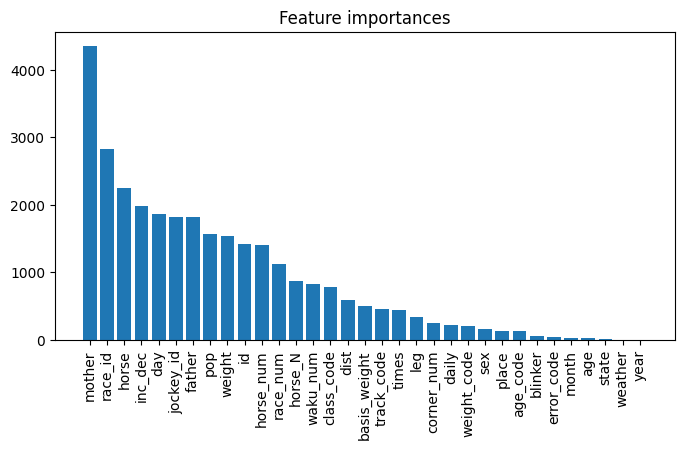

In [21]:
importances = model.feature_importances_

#値が小さい順のインデックスが返されるので、これを[::-1]で反転させている。
indices = np.argsort(importances)[::-1] 

plt.figure(figsize=(8,4))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), df2.drop(["target"], axis=1).columns[indices], rotation=90)

plt.show()

race_id, dayなどは特徴量からはずしてよさそう。
過去の獲得賞金総額などは特徴量として使えそう
mother, fatherなどはとりあえず外す。後でtf-idfでベクトル化する予定。